<a href="https://colab.research.google.com/github/sravan1320/ML-Algo/blob/master/AnalyticsVidhya_Loan_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score, KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report

In [0]:
loandata=pd.read_csv("train.csv")
loantestdata=pd.read_csv("test.csv")

In [280]:
loandata.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [281]:
loantestdata.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [282]:
loantestdata.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [0]:
#Convert Target category to numeric
loandata['Loan_Status']=loandata['Loan_Status'].astype('category').cat.codes


In [284]:
loandata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null int8
dtypes: float64(4), int64(1), int8(1), object(7)
memory usage: 58.2+ KB


In [285]:
loandata.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,614.000000,614.000000,592.000000,600.00000,564.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199,0.687296
std,6109.041673,2926.248369,85.587325,65.12041,0.364878,0.463973
min,150.000000,0.000000,9.000000,12.00000,0.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000,0.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000,1.000000


In [286]:
loandata.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [287]:
loandata.shape

(614, 13)

In [0]:
loan_copy=loandata.copy()
loantest_copy=loantestdata.copy()

In [0]:
#Drop Unneccessary columns
loan_copy.drop(['Loan_ID'],axis=1, inplace=True)

# Dropping LoanAmount & Credit_History Nan's as without LOan amount and credit history we cannot predict loan can give or not. we cannot impute these values too
loan_copy=loan_copy.dropna(subset=['LoanAmount', 'Credit_History'])

# loantest_copy=loantest_copy.dropna(subset=['LoanAmount', 'Credit_History'])



# Imput missing values

loan_copy['Gender'].fillna(loan_copy['Gender'].mode()[0], inplace=True)
loan_copy['Married'].fillna(loan_copy['Married'].mode()[0], inplace=True)
loan_copy['Dependents'].fillna(loan_copy['Dependents'].mode()[0], inplace=True)
loan_copy['Self_Employed'].fillna(loan_copy['Self_Employed'].mode()[0], inplace=True)
loan_copy['Loan_Amount_Term'].fillna(loan_copy['Loan_Amount_Term'].mean(), inplace=True)

loantest_copy['Gender'].fillna(loantest_copy['Gender'].mode()[0], inplace=True)
loantest_copy['Married'].fillna(loantest_copy['Married'].mode()[0], inplace=True)
loantest_copy['Dependents'].fillna(loantest_copy['Dependents'].mode()[0], inplace=True)
loantest_copy['Self_Employed'].fillna(loantest_copy['Self_Employed'].mode()[0], inplace=True)
loantest_copy['Loan_Amount_Term'].fillna(loantest_copy['Loan_Amount_Term'].mean(), inplace=True)
loantest_copy['LoanAmount'].fillna(loantest_copy['LoanAmount'].mean(), inplace=True)
loantest_copy['Credit_History'].fillna(loantest_copy['Credit_History'].mode()[0], inplace=True)



In [0]:
# loantest_copy.isnull().sum()

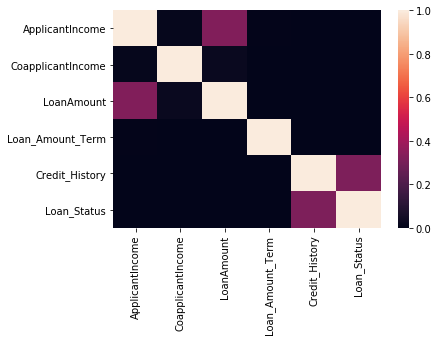

In [291]:
corr=loan_copy.corr()**2
sns.heatmap(corr)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


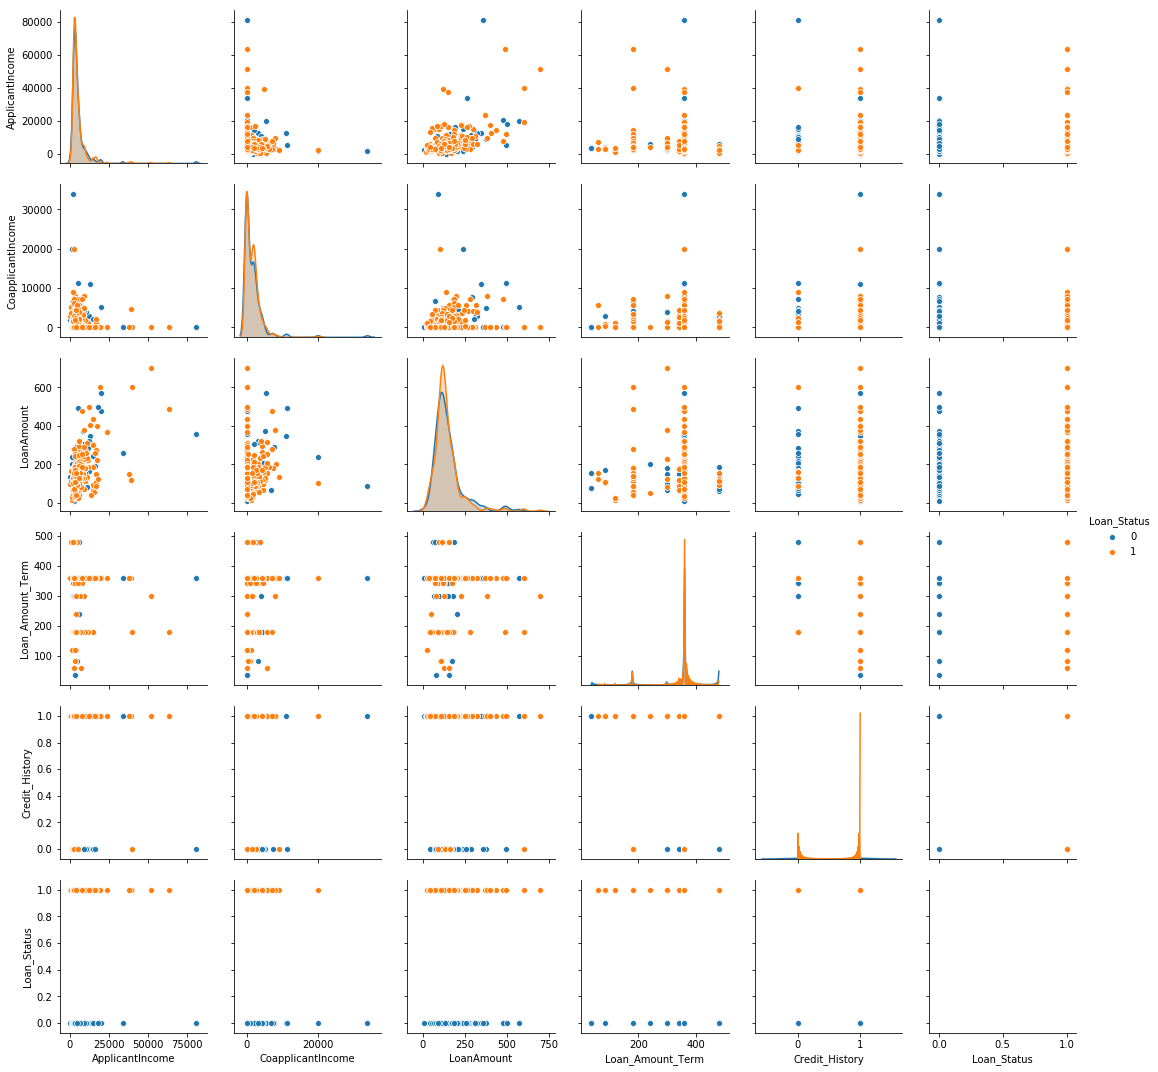

In [292]:
sns.pairplot(loan_copy, hue='Loan_Status')
plt.show()

In [293]:
loan_copy.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [0]:
# #Assumptions 
# 1) Rural users wont get loans easily
# 2) When Applicant Income & CoApplicantIncome loan will approve
# 3) When Property _Area is ther loan will approve
# 4) When applier has dependent & Maritual Status loan chances will apprve
# 5) Gender based approval

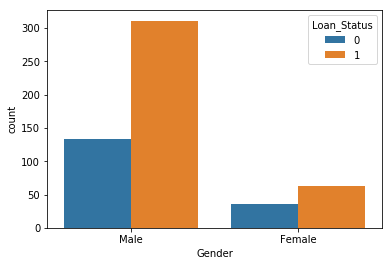

In [295]:
# loan status check based on gender

sns.countplot('Gender', hue='Loan_Status', data=loan_copy)
plt.show()

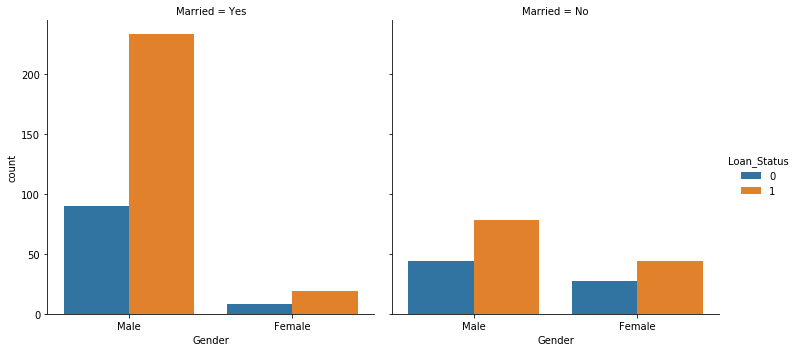

In [296]:
# loan status check based on gender & Martiual status

sns.catplot('Gender', hue='Loan_Status', data=loan_copy, col='Married', kind='count')
plt.show()

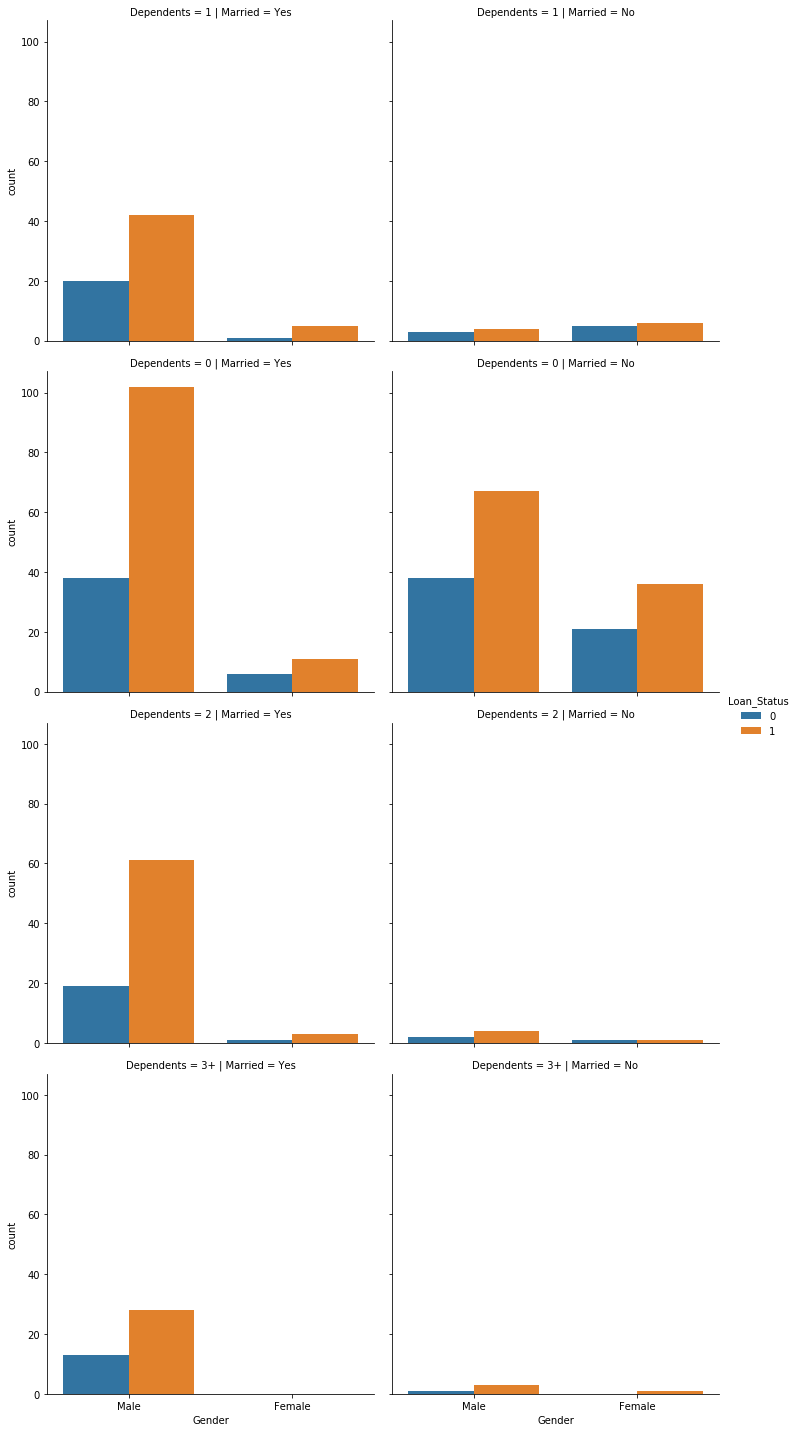

In [297]:
# loan status check based on gender & Martiual status & Dependent

sns.catplot('Gender', hue='Loan_Status', data=loan_copy, col='Married', kind='count', row='Dependents')
plt.show()

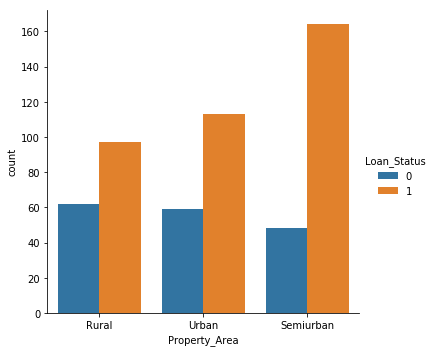

In [298]:
# loan status check based on Property Area 
sns.catplot('Property_Area', hue='Loan_Status', data=loan_copy, kind='count')
plt.show()

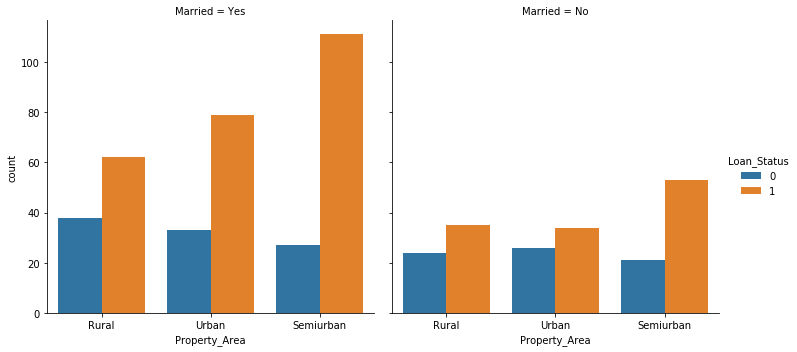

In [299]:
# loan status check based on Property_Area & Martiual status 
sns.catplot('Property_Area', hue='Loan_Status', data=loan_copy, kind='count', col='Married')
plt.show()

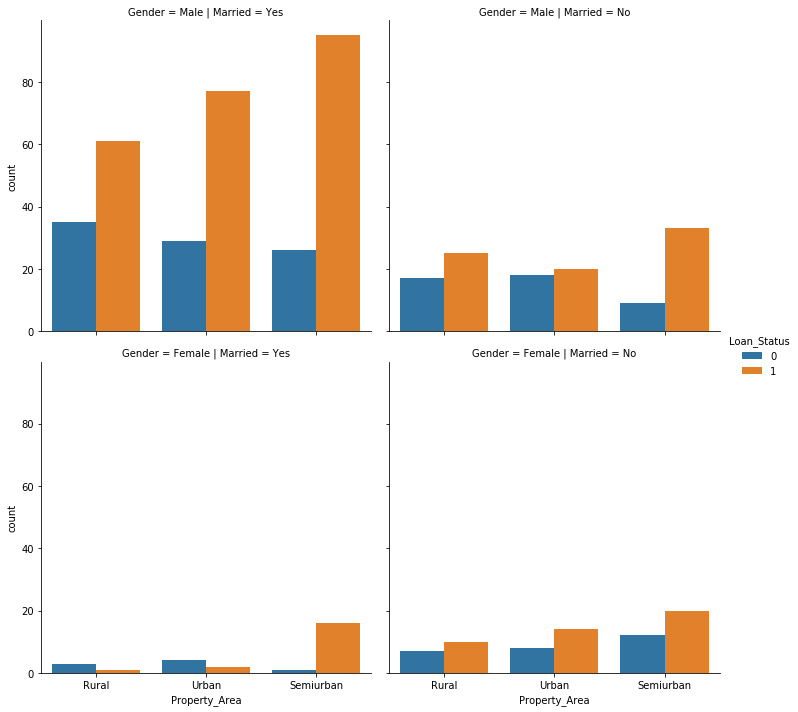

In [300]:
# loan status check based on Property_Area & Martiual status & Gender
sns.catplot('Property_Area', hue='Loan_Status', data=loan_copy, kind='count', col='Married', row='Gender')
plt.show()

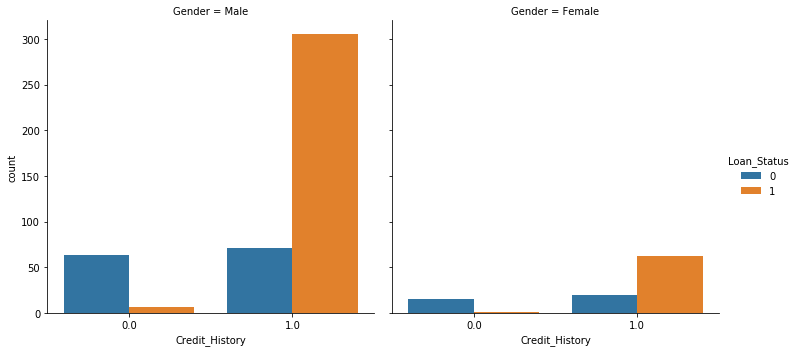

In [301]:
# loan status check based on Credit History and Gender
sns.catplot('Credit_History', hue='Loan_Status', data=loan_copy, kind='count', col='Gender')
plt.show()

In [0]:
# #Finally, as per visualization we can see
# 1) Semi Urban property has chance of loan approval
# 2) Male has chance of loan approval
# 3) Male and married has chance of loan approval
# 4) Male and married and no dependent has chance of loan approval
# 5) Credit History 1 has chance of loan approval

In [303]:
loan_copy.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status             int8
dtype: object

In [304]:
Cat_Cols=[]
for i in loan_copy.columns:
  if(loan_copy[i].dtypes=='object'):
    Cat_Cols.append(i)

print(Cat_Cols)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [0]:
#Category Conversion

loan_copy=pd.get_dummies(loan_copy, columns=Cat_Cols, drop_first=True)
loantest_copy=pd.get_dummies(loantest_copy, columns=Cat_Cols, drop_first=True)

In [306]:
loan_copy.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
1,4583,1508.0,128.0,360.0,1.0,0,1,1,1,0,0,0,0,0,0
2,3000,0.0,66.0,360.0,1.0,1,1,1,0,0,0,0,1,0,1
3,2583,2358.0,120.0,360.0,1.0,1,1,1,0,0,0,1,0,0,1
4,6000,0.0,141.0,360.0,1.0,1,1,0,0,0,0,0,0,0,1
5,5417,4196.0,267.0,360.0,1.0,1,1,1,0,1,0,0,1,0,1


In [307]:
X=loan_copy.drop(['Loan_Status'], axis=1)
Y=(loan_copy['Loan_Status']).ravel()
print('X Shape', X.shape)
print('Y Shape', Y.shape)

X Shape (543, 14)
Y Shape (543,)


In [313]:
LR=LogisticRegression(C= 0.1, penalty= 'l1')
LR.fit(X,Y)
pred_Y=LR.predict(loantest_copy.drop(['Loan_ID','Loan_Status'], axis=1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
loantest_copy['Loan_Status']=pred_Y

In [315]:
loantest_copy.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
0,LP001015,5720,0,110.0,360.0,1.0,1,1,0,0,0,0,0,0,1,1
1,LP001022,3076,1500,126.0,360.0,1.0,1,1,1,0,0,0,0,0,1,1
2,LP001031,5000,1800,208.0,360.0,1.0,1,1,0,1,0,0,0,0,1,1
3,LP001035,2340,2546,100.0,360.0,1.0,1,1,0,1,0,0,0,0,1,1
4,LP001051,3276,0,78.0,360.0,1.0,1,0,0,0,0,1,0,0,1,1


In [0]:
loantest_copy['Loan_Status']=loantest_copy['Loan_Status'].replace(0,'N')
loantest_copy['Loan_Status']=loantest_copy['Loan_Status'].replace(1,'Y')

In [0]:
loantest_copy[['Loan_ID','Loan_Status']].to_csv(r'Sample_Submission.csv',index=False)

In [318]:
loantest_copy.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
0,LP001015,5720,0,110.0,360.0,1.0,1,1,0,0,0,0,0,0,1,Y
1,LP001022,3076,1500,126.0,360.0,1.0,1,1,1,0,0,0,0,0,1,Y
2,LP001031,5000,1800,208.0,360.0,1.0,1,1,0,1,0,0,0,0,1,Y
3,LP001035,2340,2546,100.0,360.0,1.0,1,1,0,1,0,0,0,0,1,Y
4,LP001051,3276,0,78.0,360.0,1.0,1,0,0,0,0,1,0,0,1,Y
